<h1><center> Assignment 1: EDA United Nations General Debate Corpus  </center></h1>



## Read UNGDC

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
#nltk.download('punkt')
#nltk.download('stopwords')
nltk.download('vader_lexicon')
sessions = np.arange(25, 78)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_codes = pd.read_csv('UNSD — Methodology.csv', sep=';')

df_un_merged = df_speech.merge(df_codes[['Country or Area','ISO-alpha3 Code']], how='left', left_on='ISO-alpha3 Code', right_on='ISO-alpha3 Code')
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)
df_un_merged["Speech"] = df_un_merged["Speech"].str.lower()




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/wolfson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load/Create Sentiment Intensity Analyzer and merge it with UN data


In [2]:
sia = SentimentIntensityAnalyzer()

try:
    with open('sia.pickle', 'rb') as handle:
        sia_columns = pickle.load(handle)
except:
    x=df_un_merged["Speech"].apply(sia.polarity_scores)
    sia_columns = pd.DataFrame(x.to_list())
    with open('sia.pickle', 'wb') as handle:
        pickle.dump(sia_colomns, handle)

df_un_merged = df_un_merged.reset_index().merge(sia_columns, how='left', left_index=True, right_index=True)
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)

In [3]:
display(df_un_merged)

Session  \
Year ISO-alpha3 Code            
1970 LBR                   25   
     TTO                   25   
     KWT                   25   
     SOM                   25   
     SDN                   25   
...                       ...   
2020 PRY                   75   
     NAM                   75   
2021 UKR                   76   
2022 RUS                   77   
     UKR                   77   

                                                                 Speech  \
Year ISO-alpha3 Code                                                      
1970 LBR              49.\t it gives me great pleasure, mr. presiden...   
     TTO              135.\t  before commencing my statement, i shou...   
     KWT              1.\t   mr. president, your election to the aug...   
     SOM              107.\t it is with great pleasure that my deleg...   
     SDN              126.\t in this anniversary year the general as...   
...                                                                 ...   
2020 PRY              president of the general assembly,\nexcellenci...   
     NAM              your excellency, volkan bozkir, president of t...   
2021 UKR              only pronounced in the un general assembly in ...   
2022 RUS              seventy-seventh session,\n \n12th & 13th meeti...   
     UKR              statement\nby president of ukraine h.e. mr. vo...   

                          Country or Area    neg    neu    pos  compound  
Year ISO-alpha3 Code                                                      
1970 LBR                          Liberia  0.080  0.719  0.201    1.0000  
     TTO              Trinidad and Tobago  0.040  0.816  0.144    0.9999  
     KWT                           Kuwait  0.082  0.760  0.158    0.9997  
     SOM                          Somalia  0.105  0.731  0.163    0.9999  
     SDN                            Sudan  0.113  0.730  0.157    0.9997  
...                                   ...    ...    ...    ...       ...  
2020 PRY                         Paraguay  0.098  0.725  0.177    0.9964  
     NAM                          Namibia  0.067  0.721  0.213    0.9997  
2021 UKR                          Ukraine  0.084  0.779  0.137    0.9993  
2022 RUS               Russian Federation  0.128  0.736  0.136    0.9417  
     UKR                          Ukraine  0.167  0.661  0.172   -0.9366  

[8484 rows x 7 columns]

## Run bag of words

In [4]:
count_vect = CountVectorizer(lowercase=True, \
                             stop_words='english',\
                             analyzer='word',\
                            token_pattern=r"[a-z]+'?[a-z]+", \
                            min_df=100, ngram_range=(1,1))

count_vect_bigram = CountVectorizer(lowercase=True, \
                             stop_words='english',\
                             analyzer='word',\
                            token_pattern=r"[a-z]+'?[a-z]+", \
                            min_df=100, ngram_range=(2,2))

X_counts = count_vect.fit_transform(df_un_merged["Speech"])
X_counts_bigram = count_vect_bigram.fit_transform(df_un_merged["Speech"])

X_counts_tf = TfidfTransformer(use_idf=True).fit_transform(X_counts)
words_list = count_vect.get_feature_names_out()
words_list_bigram = count_vect_bigram.get_feature_names_out()
X_counts = pd.DataFrame(X_counts.toarray(), columns=words_list)
X_counts_bigram = pd.DataFrame(X_counts_bigram.toarray(), columns=words_list_bigram)
#X_counts = pd.DataFrame(X_counts_tf.toarray(), columns=words_list)

# EDA

In [5]:
amount_of_words = X_counts.sum().sort_values(ascending=False)
amount_of_words_bigram = X_counts_bigram.sum().sort_values(ascending=False)

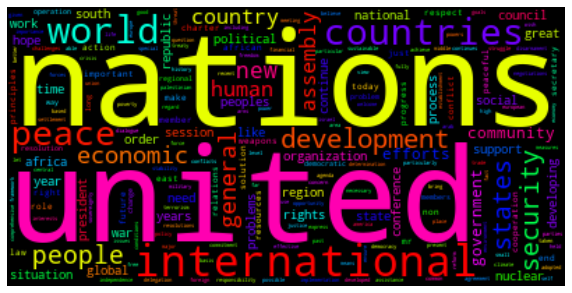

In [6]:
cloud = WordCloud(max_font_size=100, background_color="black", colormap="hsv")\
.generate_from_frequencies(amount_of_words)

plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

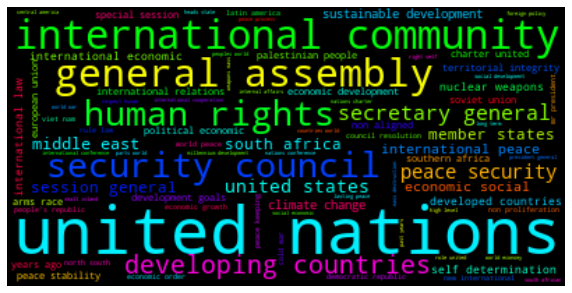

In [7]:
cloud = WordCloud(max_font_size=100, background_color="black", colormap="hsv")\
.generate_from_frequencies(amount_of_words_bigram)

plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

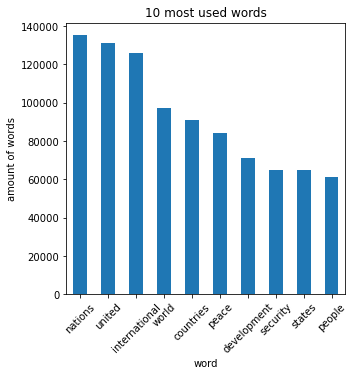

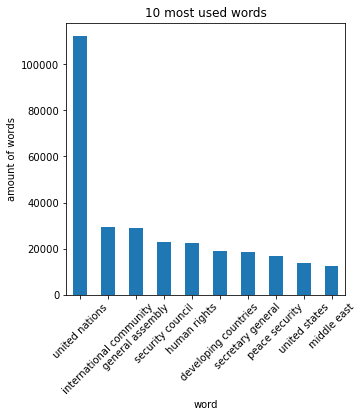

In [8]:
plt.figure(figsize=(5,5))

amount_of_words[0:10].plot.bar()
plt.xticks(rotation=45)
plt.xlabel("word")
plt.ylabel("amount of words")
plt.title("10 most used words")

plt.figure(figsize=(5,5))

amount_of_words_bigram[0:10].plot.bar()
plt.xticks(rotation=45)
plt.xlabel("word")
plt.ylabel("amount of words")
plt.title("10 most used words")
plt.show()

## Merge UNGDC with bag of words

In [9]:
df_un_merged = df_un_merged.reset_index().merge(X_counts, how='left', left_index=True, right_index=True)
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)


## Read happiness report and merge with country codes to get ISO-alpha3 Code

In [10]:
happinessdataframe = pd.read_excel('DataForTable2.1.xls')
df_happiness_merged = happinessdataframe.merge(df_codes[['Country or Area','ISO-alpha3 Code']], how='left', left_on='Country name', right_on='Country or Area')
df_happiness_merged.set_index(['year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.index.rename(['Year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.drop(columns=['Country name','Country or Area'], inplace=True)

## Merge UNGDC with happiness report by Multiple index Year, ISO

In [11]:
df_un_merged = df_un_merged.merge(df_happiness_merged, how='left', left_index=True, right_index=True)

## Build Regression for Life Ladder

### remove NaN rows from Life Ladder

In [12]:
# remove na from rows
x=df_un_merged.dropna(subset=['Life Ladder'])
display(x)

Session  \
Year ISO-alpha3 Code            
2005 AUS                   60   
     BEL                   60   
     BRA                   60   
     CAN                   60   
     CZE                   60   
...                       ...   
2020 UZB                   75   
     ZAF                   75   
     ZMB                   75   
     ZWE                   75   
2021 UKR                   76   

                                                                 Speech  \
Year ISO-alpha3 Code                                                      
2005 AUS              australia is a founding\nmember of the united ...   
     BEL              allow me to congratulate you most warmly, sir,...   
     BRA              i should like\nto extend my warmest congratula...   
     CAN              the\nsixtieth anniversary of the united nation...   
     CZE              let me begin by\ncongratulating mr. eliasson o...   
...                                                                 ...   
2020 UZB              distinguished president volkan bozkir!\ndistin...   
     ZAF              president of the general assembly, secretary-g...   
     ZMB              your excellency mr. volkan bozkir, president o...   
     ZWE              your excellency, ambassador volkan bozkir, pre...   
2021 UKR              only pronounced in the un general assembly in ...   

                     Country or Area    neg    neu    pos  compound  ababa  \
Year ISO-alpha3 Code                                                         
2005 AUS                   Australia  0.147  0.692  0.161   -0.9688      0   
     BEL                     Belgium  0.069  0.715  0.216    0.9998      0   
     BRA                      Brazil  0.103  0.725  0.172    0.9990      0   
     CAN                      Canada  0.096  0.718  0.186    0.9997      0   
     CZE                     Czechia  0.104  0.707  0.188    0.9988      0   
...                              ...    ...    ...    ...       ...    ...   
2020 UZB                  Uzbekistan  0.060  0.772  0.168    0.9995      0   
     ZAF                South Africa  0.103  0.728  0.168    0.9984      0   
     ZMB                      Zambia  0.042  0.749  0.210    0.9989      0   
     ZWE                    Zimbabwe  0.046  0.772  0.182    0.9995      0   
2021 UKR                     Ukraine  0.084  0.779  0.137    0.9993      0   

                      abandon  abandoned  ...  Life Ladder  \
Year ISO-alpha3 Code                      ...                
2005 AUS                    0          0  ...     7.340688   
     BEL                    0          0  ...     7.262290   
     BRA                    0          0  ...     6.636771   
     CAN                    0          0  ...     7.418048   
     CZE                    0          0  ...     6.439257   
...                       ...        ...  ...          ...   
2020 UZB                    0          0  ...     5.841930   
     ZAF                    0          0  ...     4.946801   
     ZMB                    0          0  ...     4.837992   
     ZWE                    0          0  ...     3.159802   
2021 UKR                    0          0  ...     5.311355   

                      Log GDP per capita  Social support  \
Year ISO-alpha3 Code                                       
2005 AUS                       10.650703        0.967892   
     BEL                       10.743808        0.934875   
     BRA                        9.438745        0.882923   
     CAN                       10.646541        0.961552   
     CZE                       10.321686        0.918759   
...                                  ...             ...   
2020 UZB                        8.899984        0.849565   
     ZAF                        9.446663        0.891050   
     ZMB                        8.094933        0.766872   
     ZWE                        8.117733        0.717243   
2021 UKR                        9.462497        0.879309   

             

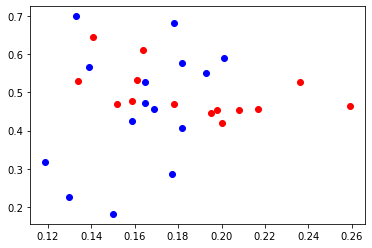

In [13]:
fig, ax = plt.subplots()
ax.scatter(x.loc[:,'AUS',:]['pos'], x.loc[:,'AUS',:]['Confidence in national government'],c='red')
ax.scatter(x.loc[:,'ZWE',:]['pos'], x.loc[:,'ZWE',:]['Confidence in national government'],c='blue')

### Split data set

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


y = x['Life Ladder'].values
features=['pos','neg']
# splitting the data
x_rem, x_test, y_rem, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.3, random_state = 42)






### Hyperparameters tunning based grid search on validation data set

In [16]:
# Create grid of parameters to test through cross-validation
param_grid = {'polynomialfeatures__degree': np.arange(1,5)}

pipe = make_pipeline( PolynomialFeatures(), LinearRegression())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_valid[features], y_valid);


### Fit the best estimator on train set

In [17]:
grid.best_estimator_.fit(x_train[features], y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

In [18]:
y_pred = grid.best_estimator_.predict(x_test[features])


# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")

Model accuracy:
Mean squared error: 1.15
Variance score: 0.03



## Random forest and gradient boost

In [23]:
# Create grid of parameters to test through cross-validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
param_grid = {'max_depth': [10,50, 100, 200, 300]}
grid_forest = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_forest.fit(x_valid[features], y_valid);

In [26]:
y_pred = grid_forest.best_estimator_.predict(x_test[features])
grid_forest.best_estimator_
# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")


Model accuracy:
Mean squared error: 1.37
Variance score: -0.16



In [27]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(x_train[features], y_train)
y_pred = reg.predict(x_test[features])

# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")


Model accuracy:
Mean squared error: 1.24
Variance score: -0.05

